Сталь – один из важнейших строительных материалов современности. Стальные здания устойчивы к естественному и искусственному износу, что сделало этот материал повсеместно распространенным во всем мире. Чтобы сделать производство стали более эффективным, этот конкурс поможет выявить дефекты.


ссылка на каггл с этим соревнованием - https://www.kaggle.com/c/severstal-steel-defect-detection

### Постановка задачи :

Этот конкурс представляет собой двойной конкурс: классифицируйте тип дефекта стали, а также сегментируйте части изображения, содержащие дефект.



In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

In [88]:
data = pd.read_csv('train.csv')

In [89]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [90]:
data.shape

(7095, 3)

У нас 7095 и три фичи

# Разведочный анализ данных

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

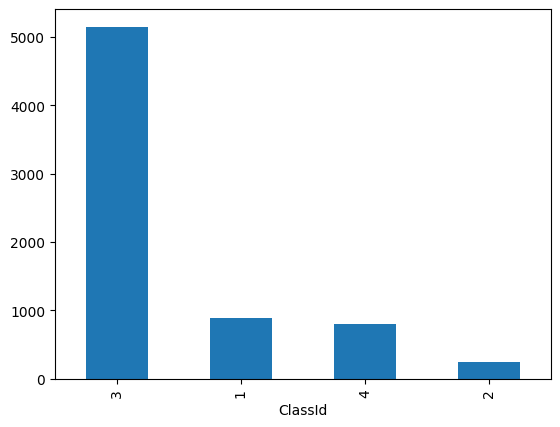

In [91]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

больше всего меток третьего класса

Перекос данных, поэтому выполним аугментацию.

In [92]:
import cv2

In [93]:
# https://unix.stackexchange.com/questions/669652/how-to-automatically-replace-mimetype-when-unzipping
!unzip "train_images.zip" -d "train_images" -o

Archive:  train_images.zip
caution: filename not matched:  -o


In [94]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    try:
      image=cv2.imread("train_images/{}".format(img),cv2.IMREAD_COLOR)
      image = cv2.resize(image,(120,120))
      l1.append(image)
      l2.append(ClassId)
    except:
      continue





100%|██████████| 7095/7095 [00:03<00:00, 2201.82it/s]


array([[[  2,   2,   2],
        [  1,   1,   1],
        [  2,   2,   2],
        ...,
        [ 74,  74,  74],
        [ 60,  60,  60],
        [ 64,  64,  64]],

       [[  2,   2,   2],
        [  1,   1,   1],
        [  2,   2,   2],
        ...,
        [ 73,  73,  73],
        [ 66,  66,  66],
        [ 65,  65,  65]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  2,   2,   2],
        ...,
        [ 75,  75,  75],
        [ 65,  65,  65],
        [ 61,  61,  61]],

       ...,

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [114, 114, 114],
        [114, 114, 114],
        [105, 105, 105]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [112, 112, 112],
        [109, 109, 109],
        [108, 108, 108]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [117, 117, 117],
        [109, 109, 109],
        [109, 109, 109]]], dtype=uint8)
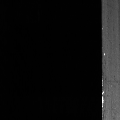

In [95]:
l1[0]

In [96]:
len(l1)

351

Проверка изображений случайной стали, чтобы проверить, дефектна ли она или нет.

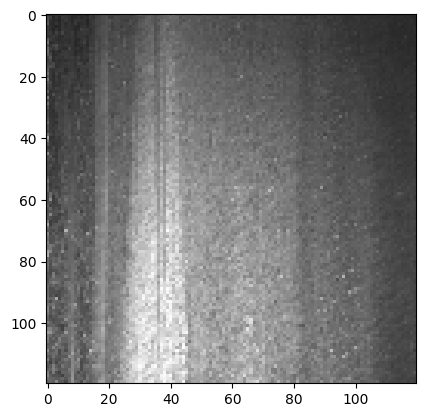

In [97]:
i = 15
plt.imshow(l1[i])

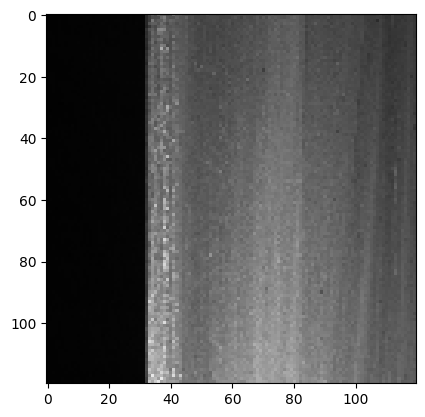

In [98]:
i = 16
plt.imshow(l1[i])

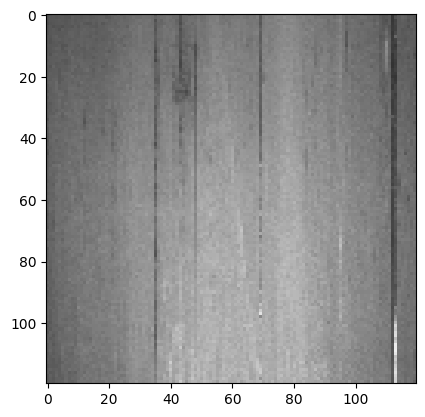

In [99]:
i = 90
plt.imshow(l1[i])

Выполним one-hot кодировку

In [100]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)


In [101]:
X.shape

(351, 120, 120, 3)

In [102]:
y.shape

(351,)

# Борьба с дибалансом

для борьбы с дисбалансом выполним случайное сэмплирование

In [103]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X , y)
X = X.reshape(-1,120,120,3)

In [104]:
X.shape

(984, 120, 120, 3)

In [105]:

y = to_categorical(y)

In [106]:
y

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

разделим на тренировку и валидацию

In [107]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [108]:
print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (787, 120, 120, 3)
x_test размер: (197, 120, 120, 3)
y_train размер: (787, 4)
y_test размер: (197, 4)


# Построение нейронной сети  в 3 слоя и график обучения

In [109]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(Flatten())
model.add(Dense(4,activation="softmax"))

In [110]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [111]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
7/7 [==============================] - 1s 88ms/step - loss: 16.4103 - accuracy: 0.2605 - val_loss: 5.9214 - val_accuracy: 0.4010
Epoch 2/10
7/7 [==============================] - 0s 43ms/step - loss: 7.0279 - accuracy: 0.2999 - val_loss: 3.0490 - val_accuracy: 0.3807
Epoch 3/10
7/7 [==============================] - 0s 40ms/step - loss: 2.3364 - accuracy: 0.3990 - val_loss: 1.4947 - val_accuracy: 0.4518
Epoch 4/10
7/7 [==============================] - 0s 42ms/step - loss: 1.2026 - accuracy: 0.5146 - val_loss: 0.9957 - val_accuracy: 0.5787
Epoch 5/10
7/7 [==============================] - 0s 42ms/step - loss: 0.9515 - accuracy: 0.6658 - val_loss: 0.9510 - val_accuracy: 0.6701
Epoch 6/10
7/7 [==============================] - 0s 42ms/step - loss: 0.9093 - accuracy: 0.7103 - val_loss: 0.8625 - val_accuracy: 0.6954
Epoch 7/10
7/7 [==============================] - 0s 34ms/step - loss: 0.7818 - accuracy: 0.7586 - val_loss: 0.7596 - val_accuracy: 0.7056
Epoch 8/10
7/7 [==========

<Axes: title={'center': 'Loss curve'}>

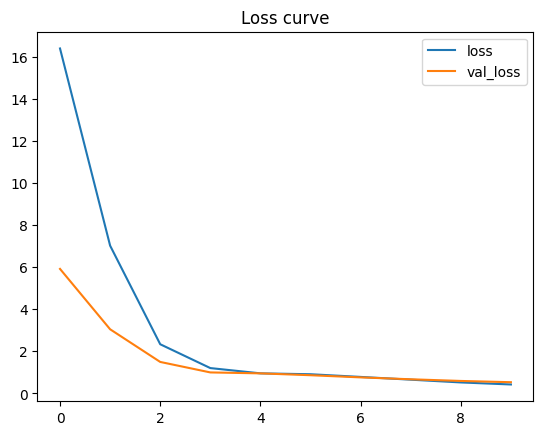

In [112]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

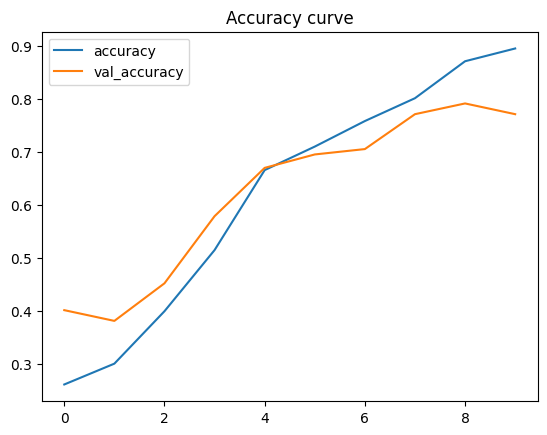

In [113]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети  в 5 слоев

In [114]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))


In [115]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [116]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
7/7 [==============================] - 3s 173ms/step - loss: 7.8358 - accuracy: 0.3062 - val_loss: 2.5246 - val_accuracy: 0.2335
Epoch 2/10
7/7 [==============================] - 0s 43ms/step - loss: 1.9697 - accuracy: 0.3520 - val_loss: 1.9506 - val_accuracy: 0.4010
Epoch 3/10
7/7 [==============================] - 0s 36ms/step - loss: 1.6415 - accuracy: 0.4041 - val_loss: 1.3499 - val_accuracy: 0.3604
Epoch 4/10
7/7 [==============================] - 0s 42ms/step - loss: 1.1576 - accuracy: 0.4854 - val_loss: 0.9635 - val_accuracy: 0.6041
Epoch 5/10
7/7 [==============================] - 0s 41ms/step - loss: 0.9267 - accuracy: 0.6239 - val_loss: 0.9155 - val_accuracy: 0.5736
Epoch 6/10
7/7 [==============================] - 0s 36ms/step - loss: 0.8792 - accuracy: 0.6429 - val_loss: 0.8701 - val_accuracy: 0.6701
Epoch 7/10
7/7 [==============================] - 0s 35ms/step - loss: 0.8091 - accuracy: 0.6938 - val_loss: 0.8034 - val_accuracy: 0.7005
Epoch 8/10
7/7 [==========

<Axes: title={'center': 'Loss curve'}>

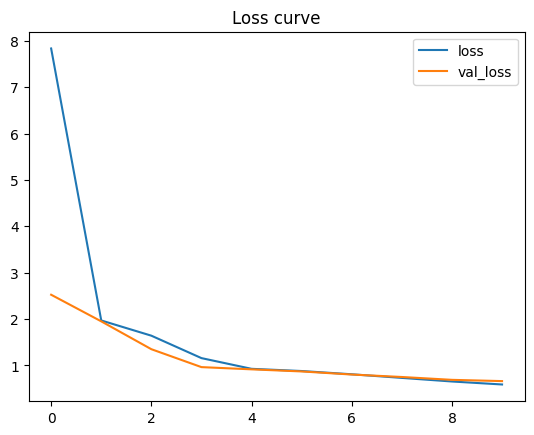

In [117]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

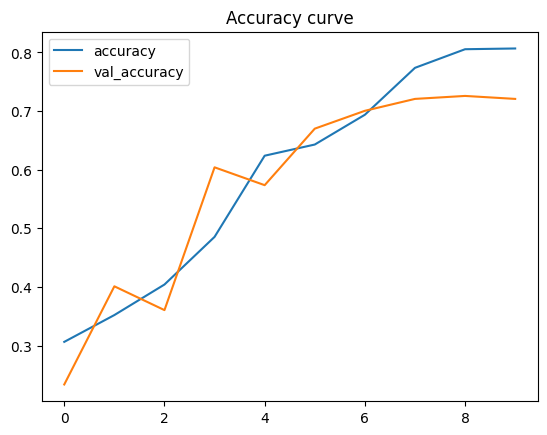

In [118]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети в 13 слоев и обучение

In [350]:
## Original
# model=Sequential()
# model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Conv2D(64,(3,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Conv2D(64,(3,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(4,4)))
# model.add(Flatten())
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(256,activation="relu"))
# model.add(Dense(4,activation="softmax"))


## +1
# model=Sequential()
# model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Conv2D(64,(3,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Conv2D(128,(3,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(4,4)))
# model.add(Flatten())
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(256,activation="relu"))
# model.add(Dense(4,activation="softmax"))


## +2
# model=Sequential()
# model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Conv2D(64,(3,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Conv2D(128,(3,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(4,4)))
# model.add(Flatten())
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(256,activation="relu"))
# model.add(Dense(4,activation="softmax"))


## 01
model=Sequential()
model.add(Conv2D(32,(6,6),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(6,6),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(128,(6,6),activation="relu"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))


## 02
# model=Sequential()
# model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Conv2D(64,(3,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Conv2D(128,(3,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(4,4)))
# model.add(Flatten())
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(256,activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(512,activation="relu"))
# model.add(Dense(4,activation="softmax"))


## 03
# model=Sequential()
# model.add(Conv2D(32,(6,6),input_shape=(120,120,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Conv2D(64,(6,6),activation="relu"))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Conv2D(64,(3,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(8,8)))
# model.add(Flatten())
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(256,activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(512,activation="relu"))
# model.add(Dense(4,activation="softmax"))

In [351]:
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

Сборка и обучение модели

In [352]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [353]:
# history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
#                     verbose=1)

history = model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

# На графике видно, Original постепенно обучался. Плавная кривая линия.
# loss плавно понижался.
# val_loss, остановился в диапазоне, 0.6 - 0.8
# Примерно на 35-ом шаге, val_loss остановился на 0.6 и постепенно приближался к 0.8
# 7/7 [==============================] - 0s 6ms/step - loss: 0.6655 - accuracy: 0.8376
# [+] Accuracy: 83.76%

# На графике видно, +1 постепенно обучался. Плавная кривая линия.
# loss плавно понижался.
# val_loss, остановился в диапазоне, 0.6 - 0.8
# Примерно на 35-ом шаге, val_loss остановился на 0.6 и постепенно приближался к 0.8
# 7/7 [==============================] - 0s 6ms/step - loss: 0.7045 - accuracy: 0.8376
# [+] Accuracy: 83.76%


# На графике видно, +2 скачкамми обучался. Резкие нестабильные линии.
# loss плавно понижался.
# val_loss, остановился в диапазоне, 0.6 - 0.8
# 7/7 [==============================] - 0s 7ms/step - loss: 0.7234 - accuracy: 0.8579
# [+] Accuracy: 85.79%

# На графике видно, 01 постепенно обучался. Плавные и Резкие полу-стабильные линии.
# 7/7 [==============================] - 0s 15ms/step - loss: 0.4062 - accuracy: 0.8934
# [+] Accuracy: 89.34%
# 7/7 [==============================] - 0s 11ms/step - loss: 0.5338 - accuracy: 0.8579
# [+] Accuracy: 85.79%

# На графике видно, 02 постепенно обучался. Плавные и Полу-резкие стабильные линии.
# 7/7 [==============================] - 0s 6ms/step - loss: 0.4968 - accuracy: 0.8680
# [+] Accuracy: 86.80%

# На графике видно, 03 постепенно обучался. Плавные и Резкие полу-стабильные линии.
# 7/7 [==============================] - 0s 10ms/step - loss: 0.4889 - accuracy: 0.8629
# [+] Accuracy: 86.29%
# Но, accuracy и val_accuracy, loss и val_loss, значения между ними, практически одинаковы.


## Original
# Epoch 1/100
# 7/7 [==============================] - 3s 126ms/step - loss: 1.3752 - accuracy: 0.2910 - val_loss: 1.3457 - val_accuracy: 0.3655
# Epoch 2/100
# 7/7 [==============================] - 0s 56ms/step - loss: 1.3488 - accuracy: 0.3634 - val_loss: 1.3031 - val_accuracy: 0.4518
# Epoch 3/100
# 7/7 [==============================] - 0s 42ms/step - loss: 1.2832 - accuracy: 0.4320 - val_loss: 1.1564 - val_accuracy: 0.4670
# Epoch 4/100
# 7/7 [==============================] - 0s 42ms/step - loss: 1.1425 - accuracy: 0.4460 - val_loss: 1.0286 - val_accuracy: 0.5127
# Epoch 5/100
# 7/7 [==============================] - 0s 42ms/step - loss: 1.0659 - accuracy: 0.4867 - val_loss: 1.0731 - val_accuracy: 0.4315
# Epoch 6/100
# 7/7 [==============================] - 0s 38ms/step - loss: 1.0781 - accuracy: 0.4638 - val_loss: 0.9746 - val_accuracy: 0.5330
# Epoch 7/100
# 7/7 [==============================] - 0s 42ms/step - loss: 1.0172 - accuracy: 0.5197 - val_loss: 0.9742 - val_accuracy: 0.5228
# Epoch 8/100
# 7/7 [==============================] - 0s 39ms/step - loss: 1.0019 - accuracy: 0.5070 - val_loss: 0.9350 - val_accuracy: 0.5381
# Epoch 9/100
# 7/7 [==============================] - 0s 40ms/step - loss: 0.9696 - accuracy: 0.5260 - val_loss: 0.9199 - val_accuracy: 0.5381
# Epoch 10/100
# 7/7 [==============================] - 0s 42ms/step - loss: 0.9568 - accuracy: 0.5197 - val_loss: 0.9109 - val_accuracy: 0.5584
# Epoch 100/100
# 7/7 [==============================] - 0s 39ms/step - loss: 0.1910 - accuracy: 0.9238 - val_loss: 0.6655 - val_accuracy: 0.8376


## +1
# Epoch 1/100
# 7/7 [==============================] - 6s 94ms/step - loss: 1.3730 - accuracy: 0.2541 - val_loss: 1.3350 - val_accuracy: 0.3655
# Epoch 2/100
# 7/7 [==============================] - 0s 43ms/step - loss: 1.3318 - accuracy: 0.3952 - val_loss: 1.2725 - val_accuracy: 0.4315
# Epoch 3/100
# 7/7 [==============================] - 0s 41ms/step - loss: 1.2708 - accuracy: 0.3926 - val_loss: 1.1413 - val_accuracy: 0.5127
# Epoch 4/100
# 7/7 [==============================] - 0s 45ms/step - loss: 1.1671 - accuracy: 0.4498 - val_loss: 1.0380 - val_accuracy: 0.4975
# Epoch 5/100
# 7/7 [==============================] - 0s 45ms/step - loss: 1.0534 - accuracy: 0.4841 - val_loss: 0.9426 - val_accuracy: 0.5228
# Epoch 6/100
# 7/7 [==============================] - 0s 43ms/step - loss: 1.0305 - accuracy: 0.5019 - val_loss: 0.9908 - val_accuracy: 0.5431
# Epoch 7/100
# 7/7 [==============================] - 0s 41ms/step - loss: 0.9947 - accuracy: 0.5172 - val_loss: 0.9459 - val_accuracy: 0.5381
# Epoch 8/100
# 7/7 [==============================] - 0s 47ms/step - loss: 0.9732 - accuracy: 0.5235 - val_loss: 0.9139 - val_accuracy: 0.5482
# Epoch 9/100
# 7/7 [==============================] - 0s 41ms/step - loss: 0.9556 - accuracy: 0.5070 - val_loss: 0.9144 - val_accuracy: 0.5330
# Epoch 10/100
# 7/7 [==============================] - 0s 43ms/step - loss: 0.9705 - accuracy: 0.5299 - val_loss: 0.8892 - val_accuracy: 0.5330
# Epoch 100/100
# 7/7 [==============================] - 0s 41ms/step - loss: 0.1446 - accuracy: 0.9441 - val_loss: 0.7045 - val_accuracy: 0.8376


## +2
# Epoch 1/100
# 7/7 [==============================] - 3s 99ms/step - loss: 1.3748 - accuracy: 0.2745 - val_loss: 1.3416 - val_accuracy: 0.2995
# Epoch 2/100
# 7/7 [==============================] - 0s 48ms/step - loss: 1.3473 - accuracy: 0.3469 - val_loss: 1.3112 - val_accuracy: 0.4416
# Epoch 3/100
# 7/7 [==============================] - 0s 47ms/step - loss: 1.3025 - accuracy: 0.3825 - val_loss: 1.2373 - val_accuracy: 0.4365
# Epoch 4/100
# 7/7 [==============================] - 0s 43ms/step - loss: 1.2024 - accuracy: 0.4409 - val_loss: 1.1125 - val_accuracy: 0.4873
# Epoch 5/100
# 7/7 [==============================] - 0s 47ms/step - loss: 1.0773 - accuracy: 0.4968 - val_loss: 1.0231 - val_accuracy: 0.4772
# Epoch 6/100
# 7/7 [==============================] - 0s 42ms/step - loss: 1.0837 - accuracy: 0.4498 - val_loss: 0.9918 - val_accuracy: 0.5228
# Epoch 7/100
# 7/7 [==============================] - 0s 43ms/step - loss: 1.0331 - accuracy: 0.5044 - val_loss: 0.9740 - val_accuracy: 0.5228
# Epoch 8/100
# 7/7 [==============================] - 0s 41ms/step - loss: 1.0175 - accuracy: 0.4994 - val_loss: 0.9432 - val_accuracy: 0.5330
# Epoch 9/100
# 7/7 [==============================] - 0s 41ms/step - loss: 0.9938 - accuracy: 0.5108 - val_loss: 0.9278 - val_accuracy: 0.5431
# Epoch 10/100
# 7/7 [==============================] - 0s 42ms/step - loss: 0.9592 - accuracy: 0.5235 - val_loss: 0.9154 - val_accuracy: 0.6142
# Epoch 100/100
# 7/7 [==============================] - 0s 49ms/step - loss: 0.1682 - accuracy: 0.9365 - val_loss: 0.7234 - val_accuracy: 0.8579

# 01
# Epoch 1/100
# 7/7 [==============================] - 3s 108ms/step - loss: 1.3777 - accuracy: 0.3100 - val_loss: 1.3613 - val_accuracy: 0.3706
# Epoch 2/100
# 7/7 [==============================] - 0s 52ms/step - loss: 1.3605 - accuracy: 0.3685 - val_loss: 1.3365 - val_accuracy: 0.3604
# Epoch 3/100
# 7/7 [==============================] - 0s 49ms/step - loss: 1.3508 - accuracy: 0.3469 - val_loss: 1.3363 - val_accuracy: 0.4162
# Epoch 4/100
# 7/7 [==============================] - 0s 50ms/step - loss: 1.2859 - accuracy: 0.4307 - val_loss: 1.1643 - val_accuracy: 0.4162
# Epoch 5/100
# 7/7 [==============================] - 0s 53ms/step - loss: 1.1620 - accuracy: 0.4447 - val_loss: 1.0089 - val_accuracy: 0.5228
# Epoch 6/100
# 7/7 [==============================] - 0s 49ms/step - loss: 1.0669 - accuracy: 0.5019 - val_loss: 0.9594 - val_accuracy: 0.5178
# Epoch 7/100
# 7/7 [==============================] - 0s 49ms/step - loss: 1.0284 - accuracy: 0.4968 - val_loss: 0.9593 - val_accuracy: 0.5330
# Epoch 8/100
# 7/7 [==============================] - 0s 48ms/step - loss: 1.0031 - accuracy: 0.5260 - val_loss: 0.9709 - val_accuracy: 0.5330
# Epoch 9/100
# 7/7 [==============================] - 0s 53ms/step - loss: 0.9837 - accuracy: 0.5019 - val_loss: 0.9436 - val_accuracy: 0.5431
# Epoch 10/100
# 7/7 [==============================] - 0s 55ms/step - loss: 0.9853 - accuracy: 0.5375 - val_loss: 0.9545 - val_accuracy: 0.5330
# Epoch 100/100
# 7/7 [==============================] - 0s 47ms/step - loss: 0.1164 - accuracy: 0.9619 - val_loss: 0.4062 - val_accuracy: 0.8934

# Epoch 1/100
# 7/7 [==============================] - 3s 109ms/step - loss: 1.3740 - accuracy: 0.2719 - val_loss: 1.3589 - val_accuracy: 0.3350
# Epoch 2/100
# 7/7 [==============================] - 0s 50ms/step - loss: 1.3537 - accuracy: 0.3571 - val_loss: 1.3339 - val_accuracy: 0.3807
# Epoch 3/100
# 7/7 [==============================] - 0s 52ms/step - loss: 1.3190 - accuracy: 0.3787 - val_loss: 1.2391 - val_accuracy: 0.5025
# Epoch 4/100
# 7/7 [==============================] - 0s 47ms/step - loss: 1.2055 - accuracy: 0.4511 - val_loss: 1.0054 - val_accuracy: 0.5381
# Epoch 5/100
# 7/7 [==============================] - 0s 48ms/step - loss: 1.0482 - accuracy: 0.5095 - val_loss: 0.9659 - val_accuracy: 0.5228
# Epoch 6/100
# 7/7 [==============================] - 0s 49ms/step - loss: 0.9881 - accuracy: 0.5146 - val_loss: 0.9227 - val_accuracy: 0.5279
# Epoch 7/100
# 7/7 [==============================] - 0s 54ms/step - loss: 0.9788 - accuracy: 0.5324 - val_loss: 0.9387 - val_accuracy: 0.5330
# Epoch 8/100
# 7/7 [==============================] - 0s 53ms/step - loss: 0.9609 - accuracy: 0.5413 - val_loss: 0.9025 - val_accuracy: 0.5482
# Epoch 9/100
# 7/7 [==============================] - 0s 55ms/step - loss: 0.9435 - accuracy: 0.5057 - val_loss: 0.9086 - val_accuracy: 0.5431
# Epoch 10/100
# 7/7 [==============================] - 0s 53ms/step - loss: 0.9103 - accuracy: 0.5642 - val_loss: 0.9300 - val_accuracy: 0.5736
# Epoch 100/100
# 7/7 [==============================] - 0s 51ms/step - loss: 0.1409 - accuracy: 0.9441 - val_loss: 0.5338 - val_accuracy: 0.8579


# 02
# Epoch 1/100
# 7/7 [==============================] - 2s 93ms/step - loss: 1.3703 - accuracy: 0.2414 - val_loss: 1.3185 - val_accuracy: 0.3756
# Epoch 2/100
# 7/7 [==============================] - 0s 42ms/step - loss: 1.3063 - accuracy: 0.4028 - val_loss: 1.2203 - val_accuracy: 0.4772
# Epoch 3/100
# 7/7 [==============================] - 0s 42ms/step - loss: 1.2061 - accuracy: 0.4524 - val_loss: 1.0569 - val_accuracy: 0.4670
# Epoch 4/100
# 7/7 [==============================] - 0s 47ms/step - loss: 1.0640 - accuracy: 0.5032 - val_loss: 1.0014 - val_accuracy: 0.5482
# Epoch 5/100
# 7/7 [==============================] - 0s 45ms/step - loss: 1.0423 - accuracy: 0.4727 - val_loss: 0.9453 - val_accuracy: 0.5330
# Epoch 6/100
# 7/7 [==============================] - 0s 41ms/step - loss: 0.9769 - accuracy: 0.5400 - val_loss: 0.9288 - val_accuracy: 0.6142
# Epoch 7/100
# 7/7 [==============================] - 0s 46ms/step - loss: 0.9564 - accuracy: 0.5311 - val_loss: 0.9124 - val_accuracy: 0.5381
# Epoch 8/100
# 7/7 [==============================] - 0s 42ms/step - loss: 0.9170 - accuracy: 0.5476 - val_loss: 0.8560 - val_accuracy: 0.6294
# Epoch 9/100
# 7/7 [==============================] - 0s 47ms/step - loss: 0.8823 - accuracy: 0.5629 - val_loss: 0.8634 - val_accuracy: 0.5584
# Epoch 10/100
# 7/7 [==============================] - 0s 47ms/step - loss: 0.8406 - accuracy: 0.5947 - val_loss: 0.8014 - val_accuracy: 0.6548
# Epoch 100/100
# 7/7 [==============================] - 0s 49ms/step - loss: 0.1888 - accuracy: 0.9314 - val_loss: 0.4968 - val_accuracy: 0.8680


# 03
# Epoch 1/100
# 7/7 [==============================] - 3s 107ms/step - loss: 1.3738 - accuracy: 0.2719 - val_loss: 1.3469 - val_accuracy: 0.3401
# Epoch 2/100
# 7/7 [==============================] - 0s 48ms/step - loss: 1.3491 - accuracy: 0.3494 - val_loss: 1.2838 - val_accuracy: 0.3401
# Epoch 3/100
# 7/7 [==============================] - 0s 55ms/step - loss: 1.2398 - accuracy: 0.4066 - val_loss: 1.0850 - val_accuracy: 0.4822
# Epoch 4/100
# 7/7 [==============================] - 0s 56ms/step - loss: 1.1221 - accuracy: 0.4536 - val_loss: 1.0727 - val_accuracy: 0.4670
# Epoch 5/100
# 7/7 [==============================] - 0s 58ms/step - loss: 1.1009 - accuracy: 0.4295 - val_loss: 1.0013 - val_accuracy: 0.5025
# Epoch 6/100
# 7/7 [==============================] - 0s 57ms/step - loss: 1.0514 - accuracy: 0.4803 - val_loss: 0.9760 - val_accuracy: 0.4975
# Epoch 7/100
# 7/7 [==============================] - 0s 53ms/step - loss: 1.0459 - accuracy: 0.5146 - val_loss: 0.9793 - val_accuracy: 0.4975
# Epoch 8/100
# 7/7 [==============================] - 0s 56ms/step - loss: 1.0117 - accuracy: 0.4956 - val_loss: 1.0085 - val_accuracy: 0.4822
# Epoch 9/100
# 7/7 [==============================] - 0s 57ms/step - loss: 1.0253 - accuracy: 0.4917 - val_loss: 0.9611 - val_accuracy: 0.5330
# Epoch 10/100
# 7/7 [==============================] - 0s 46ms/step - loss: 0.9953 - accuracy: 0.4943 - val_loss: 0.9497 - val_accuracy: 0.5228
# Epoch 100/100
# 7/7 [==============================] - 0s 48ms/step - loss: 0.1557 - accuracy: 0.9479 - val_loss: 0.4889 - val_accuracy: 0.8629

Epoch 1/100
7/7 [==============================] - 3s 109ms/step - loss: 1.3740 - accuracy: 0.2719 - val_loss: 1.3589 - val_accuracy: 0.3350
Epoch 2/100
7/7 [==============================] - 0s 50ms/step - loss: 1.3537 - accuracy: 0.3571 - val_loss: 1.3339 - val_accuracy: 0.3807
Epoch 3/100
7/7 [==============================] - 0s 52ms/step - loss: 1.3190 - accuracy: 0.3787 - val_loss: 1.2391 - val_accuracy: 0.5025
Epoch 4/100
7/7 [==============================] - 0s 47ms/step - loss: 1.2055 - accuracy: 0.4511 - val_loss: 1.0054 - val_accuracy: 0.5381
Epoch 5/100
7/7 [==============================] - 0s 48ms/step - loss: 1.0482 - accuracy: 0.5095 - val_loss: 0.9659 - val_accuracy: 0.5228
Epoch 6/100
7/7 [==============================] - 0s 49ms/step - loss: 0.9881 - accuracy: 0.5146 - val_loss: 0.9227 - val_accuracy: 0.5279
Epoch 7/100
7/7 [==============================] - 0s 54ms/step - loss: 0.9788 - accuracy: 0.5324 - val_loss: 0.9387 - val_accuracy: 0.5330
Epoch 8/100
7/7 [==

# Анализ результатов обучения

<Axes: title={'center': 'Loss curve'}>

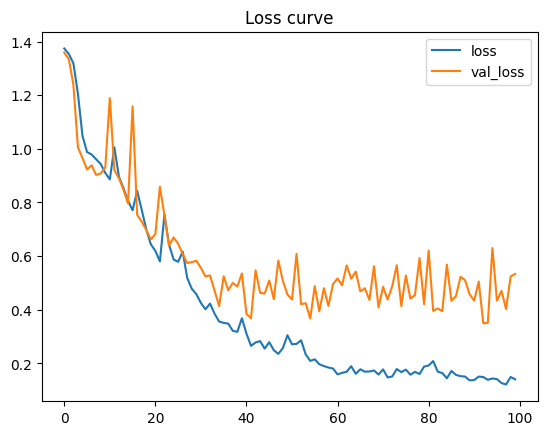

In [354]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

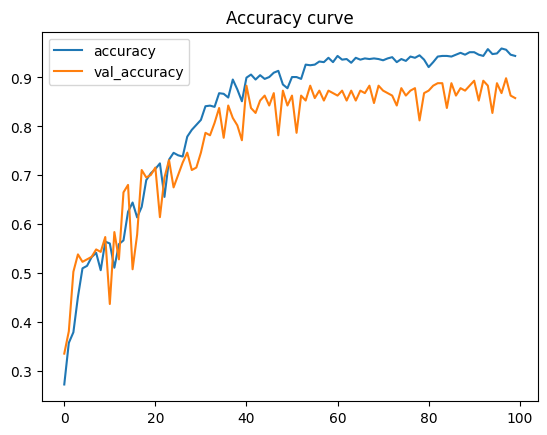

In [355]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [356]:
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

7/7 [==============================] - 0s 11ms/step - loss: 0.5338 - accuracy: 0.8579
[+] Accuracy: 85.79%


In [357]:
from keras.models import Model
model.save('my_model_steel.keras')

In [358]:
from keras.models import load_model

# loaded_model = load_model('my_model.h5')

loaded_model = load_model('my_model_steel.keras')

# Архитектура созданной нейронной сети

In [359]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_129 (Conv2D)         (None, 115, 115, 32)      3488      
                                                                 
 max_pooling2d_115 (MaxPool  (None, 38, 38, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_130 (Conv2D)         (None, 33, 33, 64)        73792     
                                                                 
 max_pooling2d_116 (MaxPool  (None, 11, 11, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_131 (Conv2D)         (None, 6, 6, 128)         295040    
                                                                 
 max_pooling2d_117 (MaxPool  (None, 1, 1, 128)       

# Тестирование на новых примерах

In [360]:
l2[:3]

[3, 3, 3]

In [361]:
X= np.array(l1[:3])
X = X/255

y = encoder.fit_transform(l2[:3])
y = np.array(y)

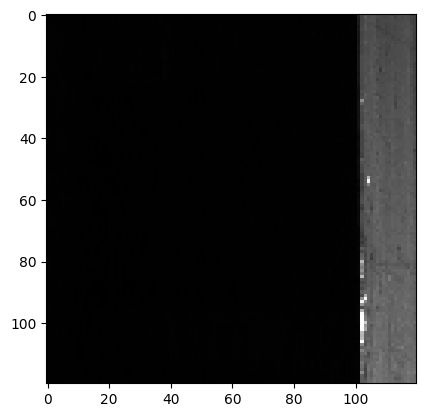

In [362]:
plt.imshow(l1[0]);

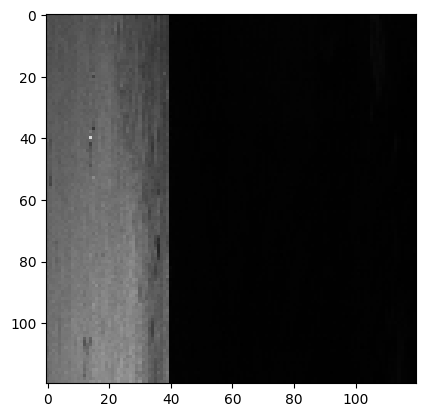

In [363]:
plt.imshow(l1[1]);

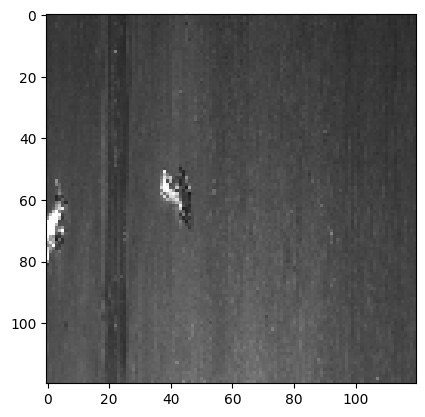

In [364]:
plt.imshow(l1[2]);

In [365]:
y =  to_categorical(y)
y

array([[1.],
       [1.],
       [1.]], dtype=float32)

In [366]:

predictions = model.predict(X)
predictions

1/1 [==============================] - 0s 174ms/step


array([[8.62470388e-01, 1.87754277e-02, 1.13986805e-01, 4.76729451e-03],
       [1.10942317e-14, 5.94828494e-13, 9.99999881e-01, 6.34891180e-08],
       [1.63347086e-10, 2.64464983e-08, 9.99999046e-01, 1.00026784e-06]],
      dtype=float32)

Здесь три эксперимента, где мы видим, что тест № 2 был с меткой 3, но неверно идентифицировался как метка 1.

In [367]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_129 (Conv2D)         (None, 115, 115, 32)      3488      
                                                                 
 max_pooling2d_115 (MaxPool  (None, 38, 38, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_130 (Conv2D)         (None, 33, 33, 64)        73792     
                                                                 
 max_pooling2d_116 (MaxPool  (None, 11, 11, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_131 (Conv2D)         (None, 6, 6, 128)         295040    
                                                                 
 max_pooling2d_117 (MaxPool  (None, 1, 1, 128)       

# описание архитектуры нейронной сети

У нас тут многослойная нейронная сеть с разными типами слоев.

теперь по поводу слоев нейронной сети и их особенностей.

1 слой - Conv2D. Он используется для выполнения двумерной свертки входных данных. Он применяет набор фильтров к входному изображению или карте объектов, перемещая их по входным данным и вычисляя скалярное произведение в каждом месте. Эта операция позволяет слою извлекать объекты и фиксировать пространственные отношения во входных данных. Уровень Conv2D обычно используется в сверточных нейронных сетях (CNN) для таких задач, как классификация изображений, обнаружение объектов и сегментация изображений.

2 слой - MaxPooling2D.  Это  операция понижающей дискретизации, которая уменьшает пространственные размеры (ширину и высоту) входного изображения или карты объектов. Он делит входные данные на непересекающиеся прямоугольники и выводит максимальное значение внутри каждого прямоугольника. Это помогает извлечь наиболее важные функции и снизить вычислительные требования для последующих слоев.

Далее эти слои повторяются еще 2 раза.

7 слой - Flatten. он преобразует входной тензор в одномерный массив, эффективно выравнивая его. Он принимает многомерный входной тензор, например двумерное изображение, и преобразует его в одномерный вектор, который можно использовать в качестве входных данных для полностью связного слоя или любого другого слоя, который ожидает одномерных входных данных.

8 слой - Dense. это полностью связный слой, который соединяет каждый нейрон предыдущего слоя с каждым нейроном текущего слоя. Он выполняет линейную операцию над входными данными, за которой следует функция активации, позволяющая сети изучать сложные закономерности и взаимосвязи в данных. Количество нейронов в плотном слое определяет размерность вывода.

9 cлой - Dropout. это метод регуляризации, используемый для уменьшения переобучения в нейронных сетях. Он случайным образом устанавливает для части входных единиц значение 0 на каждом этапе обучения, что помогает предотвратить слишком большую зависимость сети от конкретных функций или корреляций. Dropout улучшает способность модели к обобщению за счет внесения шума во время обучения и побуждает сеть изучать более надежные и независимые представления.

Далее слои повторяются.

В итоге в данной нейронной сети 12 различных слоев, и 139 780 параметров.

# Итог, результаты, тесты

---
# Original
На графике видно, Original постепенно обучался. Плавная кривая линия.

loss плавно понижался.

val_loss, остановился в диапазоне, 0.6 - 0.8

Примерно на 35-ом шаге, val_loss остановился на 0.6 и постепенно приближался к 0.8

7/7 [==============================] - 0s 6ms/step - loss: 0.6655 - accuracy: 0.8376

[+] Accuracy: 83.76%

---

---


---
# +1
На графике видно, +1 постепенно обучался. Плавная кривая линия.

loss плавно понижался.

val_loss, остановился в диапазоне, 0.6 - 0.8

Примерно на 35-ом шаге, val_loss остановился на 0.6 и постепенно приближался к 0.8

7/7 [==============================] - 0s 6ms/step - loss: 0.7045 - accuracy: 0.8376

[+] Accuracy: 83.76%
---

---


---
# +2
На графике видно, +2 скачкамми обучался. Резкие нестабильные линии.

loss плавно понижался.

val_loss, остановился в диапазоне, 0.6 - 0.8

7/7 [==============================] - 0s 7ms/step - loss: 0.7234 - accuracy: 0.8579

[+] Accuracy: 85.79%
---

---


---
# 01
На графике видно, 01 постепенно обучался. Плавные и Резкие полу-стабильные линии.

7/7 [==============================] - 0s 15ms/step - loss: 0.4062 - accuracy: 0.8934

[+] Accuracy: 89.34%

7/7 [==============================] - 0s 11ms/step - loss: 0.5338 - accuracy: 0.8579

[+] Accuracy: 85.79%
---

---


---
# 02
На графике видно, 02 постепенно обучался. Плавные и Полу-резкие стабильные линии.

7/7 [==============================] - 0s 6ms/step - loss: 0.4968 - accuracy: 0.8680

[+] Accuracy: 86.80%
---

---


---
# 03
На графике видно, 03 постепенно обучался. Плавные и Резкие полу-стабильные линии.

7/7 [==============================] - 0s 10ms/step - loss: 0.4889 - accuracy: 0.8629

[+] Accuracy: 86.29%

Но, accuracy и val_accuracy, loss и val_loss, значения между ними, практически одинаковы.
---

---





---
# Original

Epoch 10

loss: 0.9568 - accuracy: 0.5197 - val_loss: 0.9109 - val_accuracy: 0.5584

Epoch 100

loss: 0.1910 - accuracy: 0.9238 - val_loss: 0.6655 - val_accuracy: 0.8376
---

---





---
# +1

Epoch 10

loss: 0.9705 - accuracy: 0.5299 - val_loss: 0.8892 - val_accuracy: 0.5330

Epoch 100

loss: 0.1446 - accuracy: 0.9441 - val_loss: 0.7045 - val_accuracy: 0.8376
---

---





---
# +2

Epoch 10

loss: 0.9592 - accuracy: 0.5235 - val_loss: 0.9154 - val_accuracy: 0.6142

Epoch 100

loss: 0.1682 - accuracy: 0.9365 - val_loss: 0.7234 - val_accuracy: 0.8579
---

---





---
# 01

Epoch 10

loss: 0.9853 - accuracy: 0.5375 - val_loss: 0.9545 - val_accuracy: 0.5330

Epoch 100

loss: 0.1164 - accuracy: 0.9619 - val_loss: 0.4062 - val_accuracy: 0.8934

---


Epoch 10

loss: 0.9103 - accuracy: 0.5642 - val_loss: 0.9300 - val_accuracy: 0.5736

Epoch 100

loss: 0.1409 - accuracy: 0.9441 - val_loss: 0.5338 - val_accuracy: 0.8579
---

---





---
# 02

Epoch 10

loss: 0.8406 - accuracy: 0.5947 - val_loss: 0.8014 - val_accuracy: 0.6548

Epoch 100

loss: 0.1888 - accuracy: 0.9314 - val_loss: 0.4968 - val_accuracy: 0.8680
---

---





---
# 03

Epoch 10

loss: 0.9953 - accuracy: 0.4943 - val_loss: 0.9497 - val_accuracy: 0.5228

Epoch 100

loss: 0.1557 - accuracy: 0.9479 - val_loss: 0.4889 - val_accuracy: 0.8629

